***
# <font color=blue size=10>Regressão Logística</font>
***

Nesta Aula, você terá a oportunidade de utilizar o método de regressão logistica para resolver um problema prático. Vamos utilizar o dataset '***'Pima Indians Diabetes Dataset'***, para realizar a predição de diabetes para pacientes levando em consideração seus dados clínicos.

# Importando Bibliotecas

In [18]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Regressão Logística (Resumo)

A **regressão logística** é um modelo estatístico usado para tarefas de **classificação**, especialmente **binária** (ex: prever se uma pessoa está doente ou saudável). Seu objetivo é estimar a **probabilidade** de um exemplo pertencer à **classe positiva** (\(y = 1\)), com base em variáveis preditoras \(x\).

---

### Função Sigmoide

A função central da regressão logística é a **função sigmoide**, que mapeia valores reais para o intervalo (0, 1), representando uma probabilidade:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}, \quad \text{onde } z = \theta_0 + \theta_1 x_1 + \dots + \theta_n x_n
$$

Ou, de forma compacta:

$$
f_\theta(x) = \frac{1}{1 + e^{-\theta^\top x}}
$$

Essa função tem formato em "S", e suas propriedades são:

- Para entradas muito **positivas**, $\sigma(z) \to 1$
- Para entradas muito **negativas**, $\sigma(z) \to 0$

---

### Função Logit

A função **logit** é a **inversa da função sigmoide**, e é usada para modelar a relação linear entre as variáveis \(x\) e o **logaritmo das chances** (log-odds) de \(y = 1\):

$$
\text{logit}(p) = \log\left( \frac{p}{1 - p} \right)
$$

Ela transforma uma **probabilidade \(p\)** no intervalo (0, 1) em um número real \((-\infty, +\infty)\). Na regressão logística, essa relação é modelada como:

$$
\log\left( \frac{P(y=1|x)}{1 - P(y=1|x)} \right) = \theta^\top x
$$

Ou seja, os **log-odds** são uma função linear das variáveis de entrada.

---

### Regra de Decisão

Após calcular a probabilidade com a sigmoide, usamos um **limiar (threshold)** para tomar a decisão final:

$$
\hat{y} =
\begin{cases}
1, & \text{se } \sigma(z) \geq 0.5 \\
0, & \text{se } \sigma(z) < 0.5
\end{cases}
$$

Esse valor de corte pode ser ajustado, por exemplo, para priorizar sensibilidade ou especificidade em problemas médicos.

---

### Resumo:

- A regressão logística não prevê diretamente \( y = 0 \) ou \( y = 1 \), mas a **probabilidade de \( y = 1 \)**.
- Utiliza a **função sigmoide** para transformar uma combinação linear em uma probabilidade.
- A **função logit** permite modelar a relação linear nos log-odds.


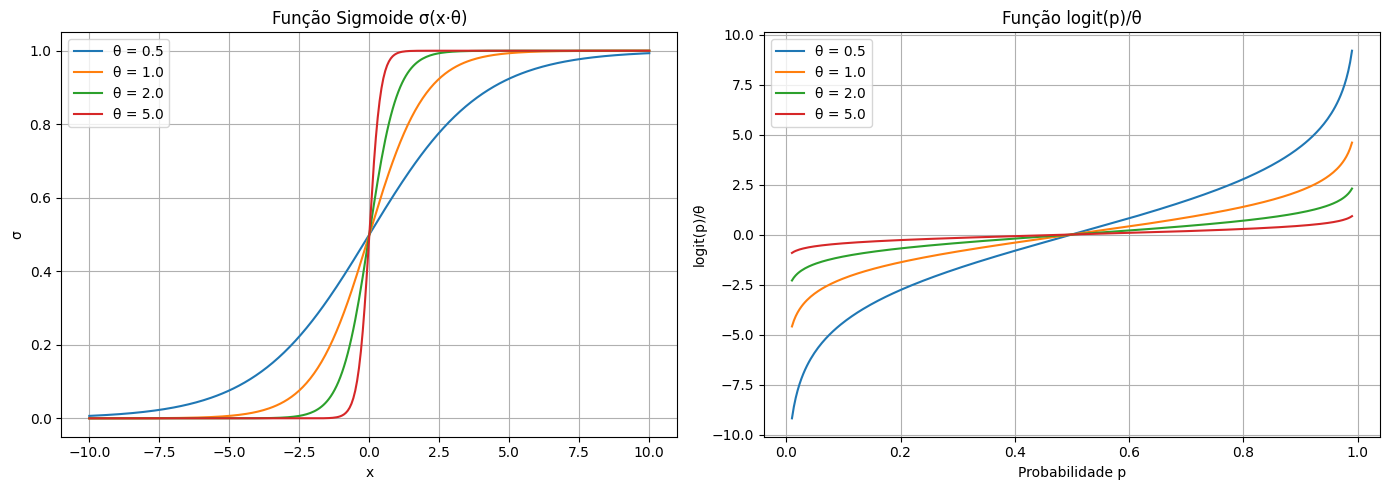

In [19]:
def sigmoid(x, theta):
    z = x * theta  # produto escalar simplificado para 1D
    return 1.0 / (1.0 + np.exp(-z))

def logit(p, theta):
    # logit inverso deslocado por theta
    return np.log(p / (1 - p)) / theta  # ajusta a escala para comparar

x = np.linspace(-10, 10, 300)
p = np.linspace(0.01, 0.99, 300)
thetas = [0.5, 1.0, 2.0, 5.0]

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Sigmoide para diferentes thetas
for theta in thetas:
    y = sigmoid(x, theta)
    axs[0].plot(x, y, label=f'θ = {theta}')
axs[0].set_title("Função Sigmoide σ(x·θ)")
axs[0].set_xlabel("x")
axs[0].set_ylabel("σ")
axs[0].legend()
axs[0].grid(True)

# Logito correspondente para diferentes thetas
for theta in thetas:
    # para manter coerência, plotar logit(p)/theta pois logit = z = x·θ
    y_logit = np.log(p / (1 - p)) / theta
    axs[1].plot(p, y_logit, label=f'θ = {theta}')
axs[1].set_title("Função logit(p)/θ")
axs[1].set_xlabel("Probabilidade p")
axs[1].set_ylabel("logit(p)/θ")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


# Baixando Dataset

In [20]:
path = "https://github.com/Lucas-Junqueira/JMR_Pratica_IA/raw/refs/heads/main/dados/diabetes.csv"
df = pd.read_csv(path)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Pima Indians Diabetes Dataset

O dataset **Pima Indians Diabetes** é um conjunto de dados amplamente utilizado em tarefas de **classificação binária na área da saúde**. Ele contém informações clínicas de mulheres de descendência Pima (povo indígena da América do Norte) com 21 anos ou mais, com o objetivo de prever se a paciente foi diagnosticada com **diabetes tipo 2** com base em diversas medições médicas.

---

### Características do Conjunto de Dados

- **Número de amostras:** 768  
- **Número de atributos:** 8 atributos numéricos  
- **Tipo de tarefa:** Classificação binária  
- **Valores ausentes:** Alguns valores implausíveis (como 0 para pressão arterial ou glicose) representam valores ausentes implícitos.

---

### Atributos

As variáveis do dataset são quantitativas e incluem dados fisiológicos e laboratoriais:

- `Pregnancies` – Número de vezes que a paciente engravidou  
- `Glucose` – Concentração de glicose plasmática após jejum de 2 horas  
- `BloodPressure` – Pressão arterial diastólica (mm Hg)  
- `SkinThickness` – Espessura da dobra cutânea do tríceps (mm)  
- `Insulin` – Nível sérico de insulina (μU/mL)  
- `BMI` – Índice de massa corporal (peso em kg / altura em m²)  
- `DiabetesPedigreeFunction` – Função que estima o histórico familiar de diabetes  
- `Age` – Idade da paciente (anos)

**Variável alvo:**

- `Outcome` – Diagnóstico de diabetes:
  - `0` → Sem diabetes  
  - `1` → Com diabetes

---

### Estatísticas Resumidas

| Atributo                   | Mínimo | Máximo |
|----------------------------|--------|--------|
| Pregnancies                | 0      | 17     |
| Glucose                    | 0      | 199    |
| BloodPressure              | 0      | 122    |
| SkinThickness              | 0      | 99     |
| Insulin                    | 0      | 846    |
| BMI                        | 0.0    | 67.1   |
| DiabetesPedigreeFunction   | 0.078  | 2.42   |
| Age                        | 21     | 81     |

**Observação:** Valores iguais a zero em colunas como `Glucose`, `BloodPressure`, `SkinThickness`, `Insulin` e `BMI` devem ser tratados como valores ausentes no pré-processamento.

---

### Distribuição das Classes

- **Sem diabetes (`0`):** 500 amostras  
- **Com diabetes (`1`):** 268 amostras

---

### Fonte dos Dados

- **Criadores:** Instituto Nacional de Diabetes e Doenças Digestivas e Renais (NIDDK) – EUA  
- **Publicador:** UCI Machine Learning Repository  
- **URL original:** [https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database)

---

### Referências

- Smith, J.W., Everhart, J.E., Dickson, W.C., Knowler, W.C., & Johannes, R.S. (1988). *Using the ADAP learning algorithm to forecast the onset of diabetes mellitus*. In Proceedings of the Symposium on Computer Applications and Medical Care, 261–265.


Nesta tarefa de classificação, desejamos predizer se o tumor é maligno ou benigno, ou seja, nosso objetivo é utilizar regressão logistica para prever a variável **'Outcome'**, que é noosa variável dependendente. Para isso, utilizaremos as variáveis independentes fornecidas pelo dataset **(Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age)**.

Contudo, antes de realizarmos a regressão logística, assim como na terefa prática anterior, vamos fazer uma análise exploratória dos dados e seu pré-processamento.

# Análise Exploratória dos Dados e Pré-Processamento

In [21]:
# Exibindo informações básicas do dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [22]:
# Exibindo estatísticas descritivas - média, desvio padrão, mínimo, máximos e quartis.
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Como foi dito na própria descrição do dataset, existem valores ausentes presentes nas colunas **'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin' e 'BMI'** e estes valores são representados como zero. Por isso, nesta parte do pré-processamento, com o intuito de preservar a natureza dos dados do dataset e evitar ruídos na regressão logistica, vamos substituir os valores ausentes pela média de sua respectiva coluna. 

<Figure size 800x500 with 0 Axes>

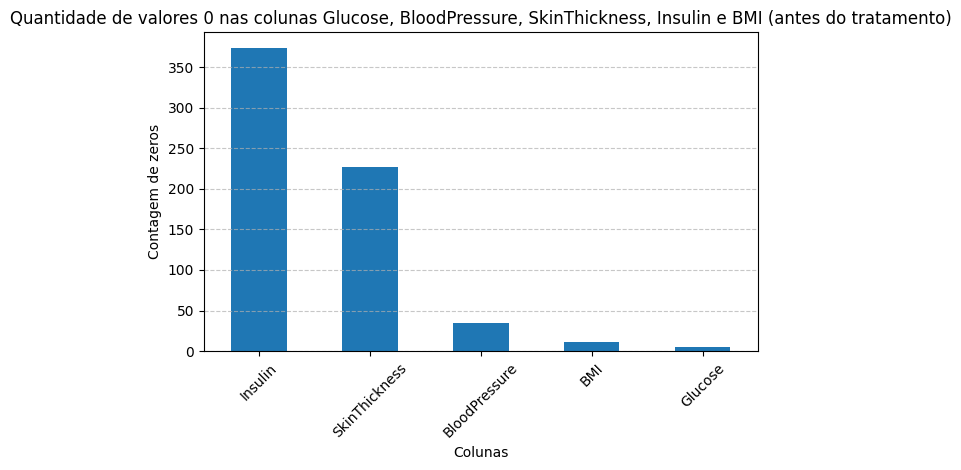

In [23]:
# Colunas onde 0 deve ser considerado valor ausente
cols_with_zero_as_missing = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Conta quantos valores 0 há em cada coluna
zero_counts = {col: (df[col] == 0).sum() for col in cols_with_zero_as_missing}

# Converte para DataFrame para visualização
zero_df = pd.DataFrame.from_dict(zero_counts, orient='index', columns=['Zero Count'])

# Plot
plt.figure(figsize=(8, 5))
zero_df.sort_values(by='Zero Count', ascending=False).plot(kind='bar', legend=False)
plt.title('Quantidade de valores 0 nas colunas Glucose, BloodPressure, SkinThickness, Insulin e BMI (antes do tratamento)')
plt.ylabel('Contagem de zeros')
plt.xlabel('Colunas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [24]:
# Substituição dos valores ausentes pela média/mediana de suas colunas

# Colunas que usarão a mediana
use_median = ['BMI', 'Insulin', 'SkinThickness']

# Substituição dos valores ausentes
for col in cols_with_zero_as_missing:
    num_zeros = (df[col] == 0).sum()
    df[col] = df[col].replace(0, np.nan)

    if col in use_median:
        value = df[col].median()
        method = "mediana"
    else:
        value = df[col].mean()
        method = "média"

    df[col] = df[col].fillna(value)
    print(f"Coluna '{col}': {num_zeros} valores zero substituídos pela {method} ({value:.2f})")

Coluna 'Glucose': 5 valores zero substituídos pela média (121.69)
Coluna 'BloodPressure': 35 valores zero substituídos pela média (72.41)
Coluna 'SkinThickness': 227 valores zero substituídos pela mediana (29.00)
Coluna 'Insulin': 374 valores zero substituídos pela mediana (125.00)
Coluna 'BMI': 11 valores zero substituídos pela mediana (32.30)


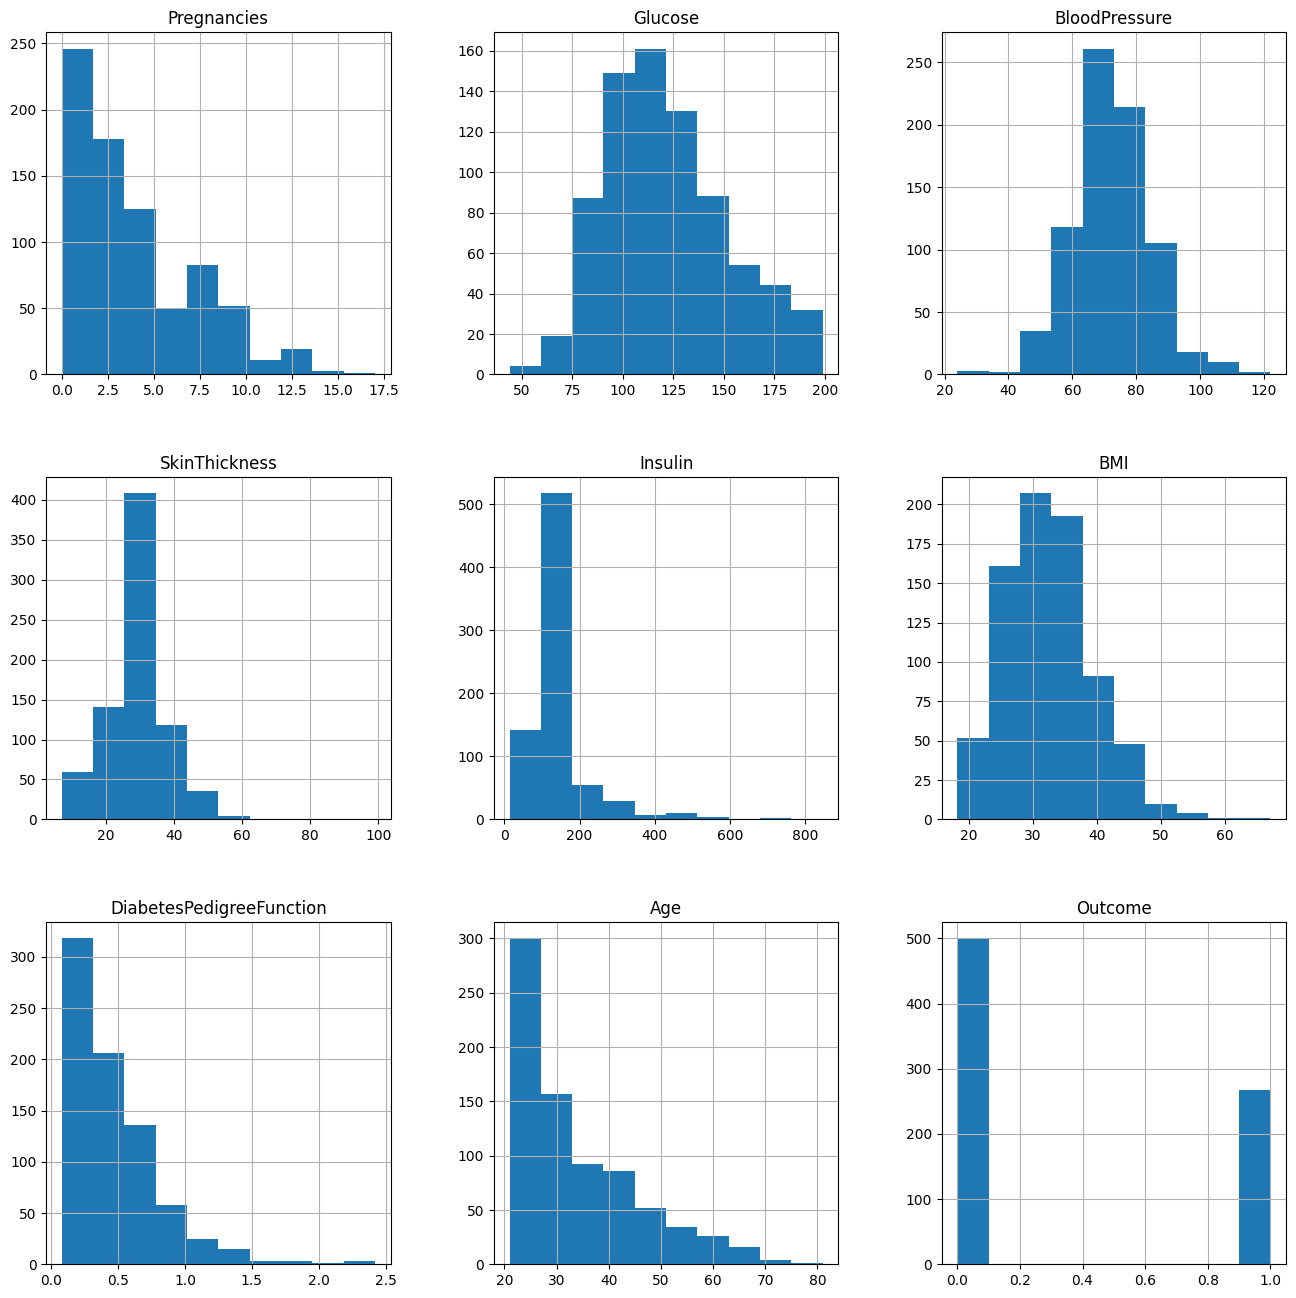

In [25]:
# Visualização da distribuição das variáveis
p = df.hist(figsize = (16,16))

Pelas distribuições das variáveis demonstradas acima, podemos perceber claramente que os dados não estão normalizados, ou seja, eles estão em escalas diferentes. No entando, algoritmos como regressão logística, KNN, SVM e PCA são sensíveis a escala dos dados, o que torna importante fazer a normalização dos dados. Para isso, padronizaremos os dados com a ferramenta **'StandardScaler()'** do scikit-learn para padronizar os dados com base na **média = 0 e desvio padrão = 1**.

In [26]:
# Seleciona apenas as colunas preditoras
predictor_cols = df.columns[:-1]  # assume que a última coluna é o alvo

# Normaliza
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[predictor_cols])

# Substitui as colunas originais pelos valores normalizados
df[predictor_cols] = X_scaled


## Matriz de Correlação

Agora, para entendermos melhor como as variáveis se relacionam, vamos plotar uma **matriz de correlação**, que mostra a relação linear entre variáveis, com valores entre -1 e 1:

- **+1**: correlação positiva perfeita (ambas aumentam juntas)
- **0**: sem correlação linear
- **-1**: correlação negativa perfeita (uma aumenta, outra diminui)

A correlação indica o quanto uma variável pode ser prevista linearmente a partir de outra.

Além disso, **Dependência linear** significa que duas variáveis estão relacionadas por uma equação do tipo:  
\[
y = a \cdot x + b
\]

Ou seja, uma pode ser expressa como uma combinação linear da outra.

Valores próximos a +1 ou -1 indicam forte dependência linear.

---

**Exemplo:** Se o índice de massa corporal (`bmi`) tem alta correlação positiva com a presença de diabetes (`Outcome`), isso indica que pacientes com maior `bmi` tendem a apresentar mais a presença da doença.


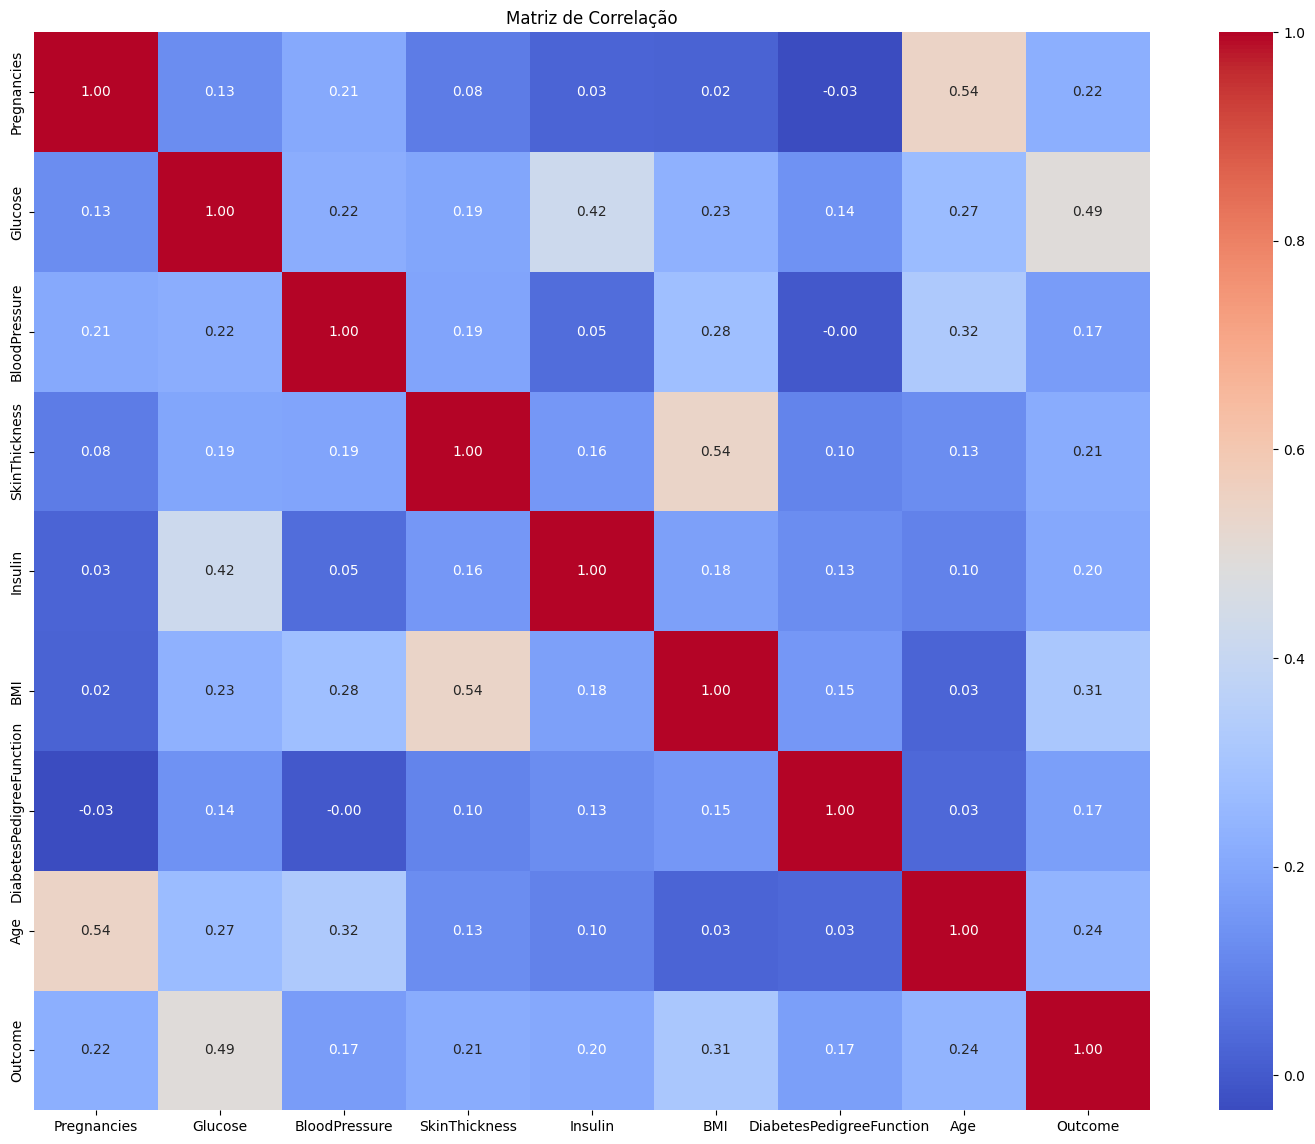

In [27]:
# Exibindo Correlação entre as variáveis
corr = df.corr()
plt.figure(figsize=(18, 14))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlação")
plt.show()

Agora, vamos visualizar separadamente como as variáveis se correlacionam com a variável **'Outcome'** especificamente

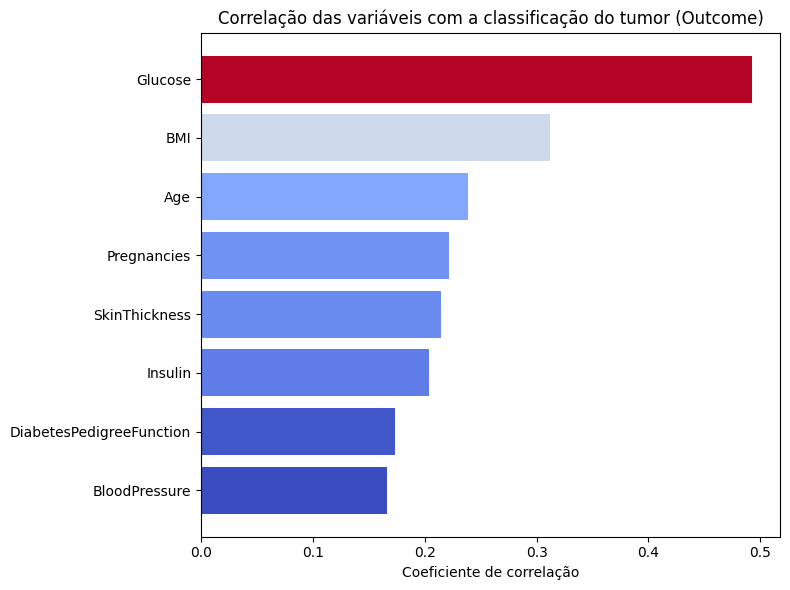

In [28]:
# Correlação com a variável alvo
correlations = df.corr()["Outcome"].drop("Outcome").sort_values(ascending=False)

# Criar um colormap coolwarm
cmap = plt.get_cmap("coolwarm")

# Normalizar os valores para o range 0-1 para mapear cores
norm = plt.Normalize(vmin=correlations.min(), vmax=correlations.max())
colors = cmap(norm(correlations.values))

plt.figure(figsize=(8, 6))

bars = plt.barh(correlations.index, correlations.values, color=colors)
plt.xlabel("Coeficiente de correlação")
plt.title("Correlação das variáveis com a classificação do tumor (Outcome)")
plt.gca().invert_yaxis()  # para deixar o maior no topo
plt.tight_layout()
plt.show()


Perceba que variáveis como 'Glucose' e 'BMI' possuem uma correlação maior com a variável **'outcome'** que as outras, ou seja, é possível que estas variáveis tenham uma importância maior na predição.

Como existem colunas poucos relacionadas com a coluna alvo, podemos excluir alguns atributos que podem não ser muito úteis para a tarefa de classificação.

In [29]:
# Seleciona colunas com correlação > 0.2 ou < -0.2, excluindo a própria 'target'
corr = df.corr()['Outcome']
selected_columns = corr[(corr.abs() > 0.2) & (corr.index != 'Outcome')].index.tolist()

print("Colunas selecionadas:", selected_columns)
df = df[selected_columns + ['Outcome']]

Colunas selecionadas: ['Pregnancies', 'Glucose', 'SkinThickness', 'Insulin', 'BMI', 'Age']


Agora, com o intuito de verificar a distribuição dos dados, plotaremos gráficos **boxplots**. Este tipo de gráfico é uma ferramenta visual fundamental para identificar características importantes, como:

- **Outliers:** Valores muito distantes da maioria dos dados que podem distorcer análises e modelos.
- **Assimetria (skewness):** Indicativo se os dados estão enviesados para valores altos ou baixos.
- **Dispersão:** Amplitude e variabilidade dos dados.
- **Mediana e Quartis:** Informam a tendência central e a dispersão sem serem influenciados por outliers.

### Por que verificar os boxplots?

- **Detecção de outliers:** Identificar e tratar valores extremos que podem afetar o desempenho dos modelos.
- **Decisões de pré-processamento:** Saber se é necessário normalizar, transformar ou filtrar dados.
- **Qualidade dos dados:** Avaliar se os dados possuem inconsistências ou erros.
- **Compreensão do dataset:** Ajudar a entender o comportamento das variáveis antes de construir modelos.

Em resumo, os boxplots são uma etapa essencial na análise exploratória para garantir que os dados estejam adequados para modelagem e evitar problemas futuros.


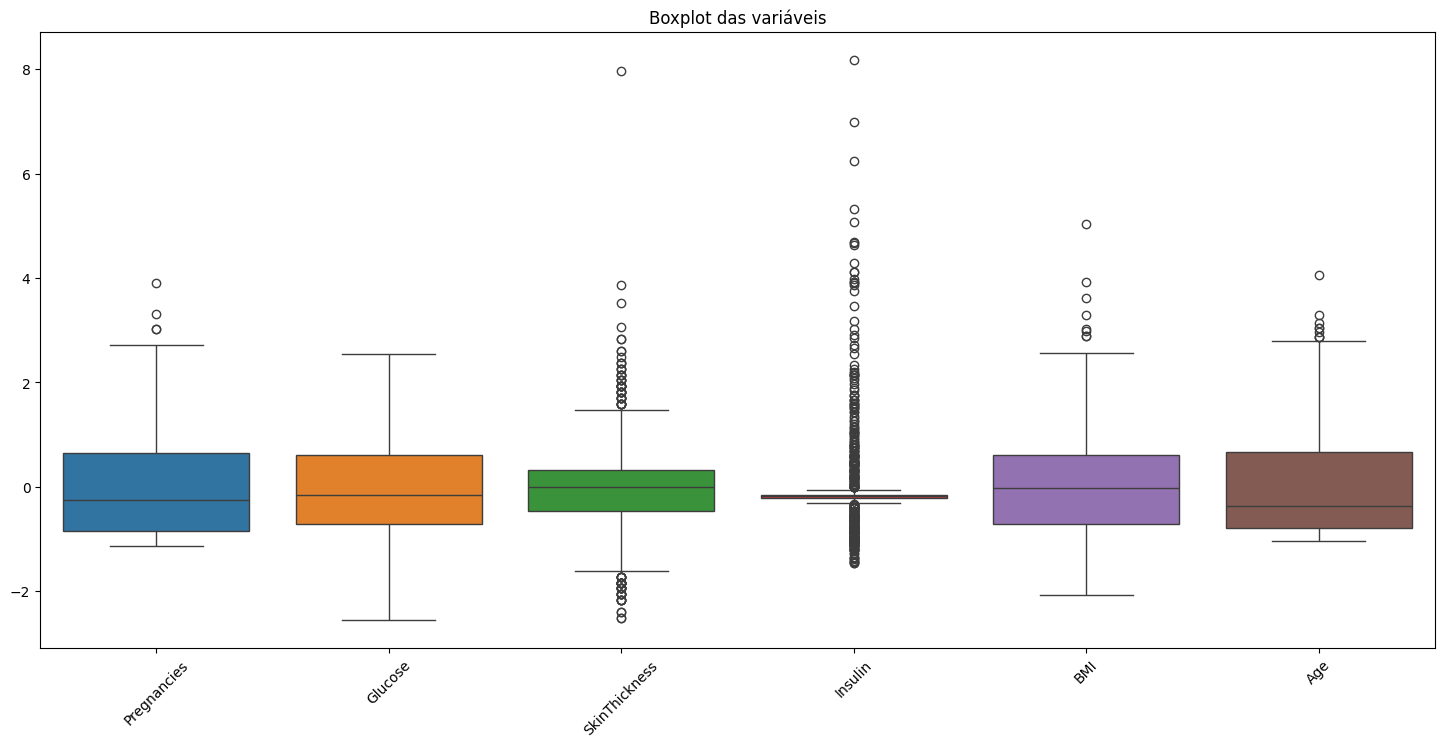

In [30]:
plt.figure(figsize=(18, 8))
sns.boxplot(data=df.iloc[:, :-1])
plt.title("Boxplot das variáveis")
plt.xticks(rotation=45)
plt.show()


No boxplot acima, podemos perceber muitos pontos que destoam da distribuição de suas respectivas colunas, por isso, vamos fazer uma filtragem de outliers com base em no intervalo de confiança arbitrário [5%, 95%].

In [31]:
# Filtragem de outliers
def remove_outliers_iqr(df, cols, con_value=0.05):
    df_clean = df.copy()
    for col in cols:
        Q1 = df_clean[col].quantile(con_value)
        Q3 = df_clean[col].quantile(1-con_value)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]
    return df_clean

# Aplica a remoção de outliers nas colunas numéricas
cols_to_check = df.columns[:-1]  # todas exceto 'outcome'
df_filtered = remove_outliers_iqr(df, cols_to_check, 0.05)

print(f"Original: {df.shape[0]} amostras")
print(f"Após remoção de outliers: {df_filtered.shape[0]} amostras")

# df_filtered.head()
df = df_filtered

Original: 768 amostras
Após remoção de outliers: 764 amostras


# Separação dos Dados Entre Treino, Validação e Teste

A separação do conjunto de dados em **treino**, **validação** e **teste** é essencial para garantir uma avaliação justa e eficaz do modelo, durente o processo de **machine learning**.

- **Treino (Training set):**
  Usado para ajustar (treinar) o modelo. O modelo aprende os padrões a partir desses dados.

- **Validação (Validation set):**
  Usado para ajustar hiperparâmetros e tomar decisões de modelagem sem viciar o teste. Serve como um "teste interno" durante o desenvolvimento.

- **Teste (Test set):**
  Usado somente no final para avaliar o desempenho real do modelo, simulando dados nunca vistos.

Essa divisão evita **overfitting**, garante uma avaliação **honesta** e melhora a **generalização** do modelo.


In [32]:
# Separar X e y
X = df.drop("Outcome", axis=1)
y = df["Outcome"]

# Etapa 1: separar TESTE (20%) e o restante (80%)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Etapa 2: separar o restante em TREINO (70%) e VALIDAÇÃO (10%)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.125, random_state=42)
# (0.125 de 80% = 10% do total)

# Verificando os tamanhos
print(f"Tamanho do conjunto de treino:     {X_train.shape[0]} amostras")
print(f"Tamanho do conjunto de validação: {X_val.shape[0]} amostras")
print(f"Tamanho do conjunto de teste:     {X_test.shape[0]} amostras")

Tamanho do conjunto de treino:     534 amostras
Tamanho do conjunto de validação: 77 amostras
Tamanho do conjunto de teste:     153 amostras


## Regressão Logistica

Agora, é chegado a hora de realizar a regressão logistica e avaliar seus resultados. Utilizaremos a ferramenta de regressão logistica **'LinearRegression'** fornecida pelo scikit-learn e as métricas de Acurácia, Precisão, Revocação e F1-Score para validar o desempenho da regressão.

### Métricas utilizadas:

#### Acurácia (Accuracy)
- Proporção de previsões corretas em relação ao total de amostras.
- Mede o desempenho geral do modelo.
- Fórmula:  
  \[
  \text{Acurácia} = \frac{TP + TN}{TP + TN + FP + FN}
  \]

#### Precisão (Precision)
- Mede a proporção de verdadeiros positivos entre todas as previsões positivas feitas pelo modelo.
- Indica a confiabilidade das previsões positivas.
- Fórmula:  
  \[
  \text{Precision} = \frac{TP}{TP + FP}
  \]

#### Revocação (Recall) ou Sensibilidade
- Mede a proporção de verdadeiros positivos que foram corretamente identificados pelo modelo.
- Indica a capacidade do modelo de encontrar todas as amostras positivas.
- Fórmula:  
  \[
  \text{Recall} = \frac{TP}{TP + FN}
  \]

#### F1-Score
- Média harmônica entre precisão e recall.
- Balanceia os dois valores para dar uma única métrica de desempenho.
- Fórmula:  
  \[
  \text{F1} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
  \]

#### Support
- Número de amostras reais em cada classe no conjunto avaliado.

---

#### Médias

- **Macro Average:** Média simples das métricas para cada classe, trata todas as classes igualmente.
- **Weighted Average:** Média ponderada pela quantidade de amostras em cada classe, útil para conjuntos com classes desbalanceadas.

In [33]:
# Treinar modelo de regressão logística
model = LogisticRegression(max_iter=1000, solver='liblinear')  # liblinear funciona bem para datasets menores
model.fit(X_train, y_train)

target_names = ['Sem diabetes', 'Com diabetes']

# Avaliar no conjunto de validação
y_val_pred = model.predict(X_val)
print("\n--- Avaliação no conjunto de VALIDAÇÃO ---")
print("Acurácia:", accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred, target_names=target_names))

# Avaliar no conjunto de teste
y_test_pred = model.predict(X_test)
print("\n--- Avaliação no conjunto de TESTE ---")
print("Acurácia:", accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred, target_names=target_names))


--- Avaliação no conjunto de VALIDAÇÃO ---
Acurácia: 0.7792207792207793
              precision    recall  f1-score   support

Sem diabetes       0.77      0.91      0.83        47
Com diabetes       0.81      0.57      0.67        30

    accuracy                           0.78        77
   macro avg       0.79      0.74      0.75        77
weighted avg       0.78      0.78      0.77        77


--- Avaliação no conjunto de TESTE ---
Acurácia: 0.8496732026143791
              precision    recall  f1-score   support

Sem diabetes       0.88      0.91      0.89       106
Com diabetes       0.77      0.72      0.75        47

    accuracy                           0.85       153
   macro avg       0.83      0.81      0.82       153
weighted avg       0.85      0.85      0.85       153



# Matriz de Confusão

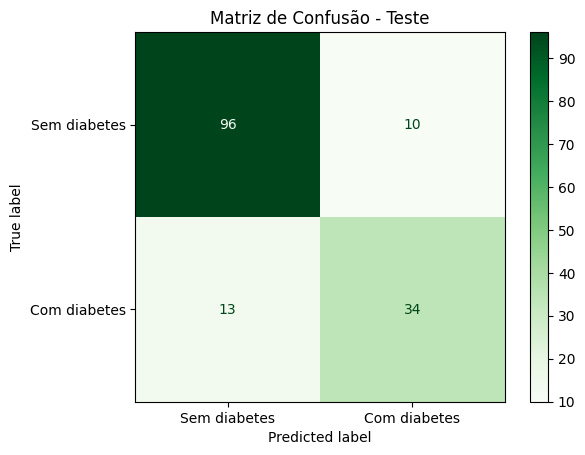

In [34]:
# Matriz de confusão - Teste
cm_test = confusion_matrix(y_test, y_test_pred)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=target_names)
disp_test.plot(cmap='Greens')
plt.title("Matriz de Confusão - Teste")
plt.show()